## Homework 08: Predicting attitudes towards racist college professors

### MACS 30100 Perspectives on Computational Modeling, Dr. Soltoff

Ellen Hsieh

4 Mar 2019

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from pyearth import Earth
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the data
gss_train = pd.read_csv('./data/gss_train.csv')
gss_test = pd.read_csv('./data/gss_test.csv')

# get training/testing dataset
x_train = gss_train.drop(['colrac'], axis=1).values
y_train = gss_train['colrac'].values
x_test = gss_test.drop(['colrac'], axis=1).values
y_test = gss_test['colrac'].values

models = {}

### Estimate statistical models

#### Logistic regression

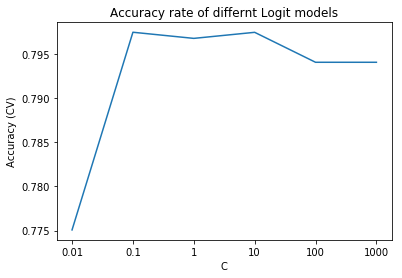

In [3]:
# tuning the logistic regression with different C parameters
c_lst = [0.01, 0.1, 1, 10, 100, 1000]
logit_lst = []
for c in c_lst:
    logit_lst.append(LogisticRegression(C=c))
logit_acc_lst =[np.mean(cross_val_score(logit, x_train, y_train, cv=KFold(10), scoring='accuracy')) 
                for logit in logit_lst]
best_logit_idx = logit_acc_lst.index(max(logit_acc_lst))  
models['Logit'] = logit_lst[best_logit_idx]

# plot the accuracy rate of logistic models
xrange= np.arange(1, len(c_lst)+ 1)
plt.plot(np.arange(1, len(c_lst)+ 1), logit_acc_lst)
plt.title('Accuracy rate of differnt Logit models')
plt.ylabel('Accuracy (CV)')
plt.xlabel('C')
plt.xticks(xrange, c_lst)
plt.show()

#### Naive Bayes

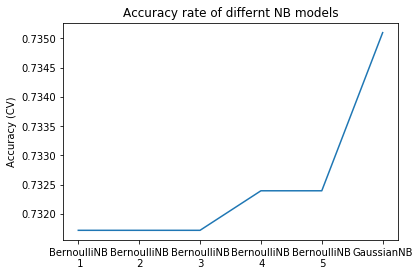

In [4]:
# tuning NB models with different alpha
nb_lst = []
nb_names_lst = []
for i in range(1, 6):
    nb_lst.append(BernoulliNB(alpha=i))
    nb_names_lst.append('BernoulliNB\n {}'.format(i))
nb_lst.append(GaussianNB())
nb_names_lst.append('GaussianNB')
nb_acc_lst= [np.mean(cross_val_score(nb, x_train, y_train, cv=KFold(10), scoring='accuracy')) for nb in nb_lst]
models['NB'] = GaussianNB()

# plot the accuracy rate for differnt NB models
xrange = np.arange(1, len(nb_lst) + 1)
plt.plot(xrange, nb_acc_lst)
plt.title('Accuracy rate of differnt NB models')
plt.ylabel('Accuracy (CV)')
plt.xticks(xrange, nb_names_lst)
plt.show()

#### K-nearest neighbors

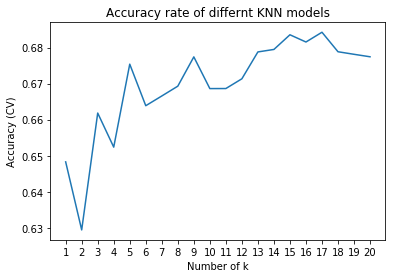

In [5]:
# tuning KNN models with different k
knn_lst = []
for k in range(1, 21):
    knn_lst.append(KNeighborsClassifier(n_neighbors=k))
knn_acc_lst = [np.mean(cross_val_score(knn, x_train, y_train, cv=KFold(10), scoring='accuracy')) for knn in knn_lst]
best_knn_idx = knn_acc_lst.index(max(knn_acc_lst))
models['KNN'] = knn_lst[best_knn_idx]

# plot the accuracy rate of different KNN models
xrange = np.arange(1, len(knn_lst) + 1)
plt.plot(xrange, knn_acc_lst)
plt.title('Accuracy rate of differnt KNN models')
plt.xlabel('Number of k')
plt.ylabel('Accuracy (CV)')
plt.xticks(xrange)
plt.show()

#### Ridge regression

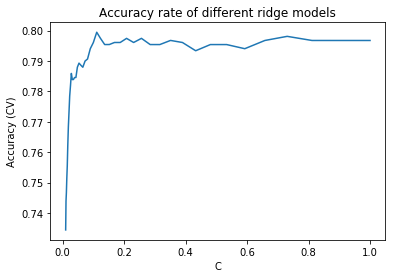

In [6]:
# tuning ridge models with differnt C parameter
c_lst = np.logspace(-2, 0, 45)
ridge_lst = []
for c in c_lst:
    ridge_lst.append(LogisticRegression(C=c, penalty='l1'))
ridge_acc_lst = [np.mean(cross_val_score(ridge, x_train, y_train, cv=KFold(10), scoring='accuracy')) for ridge in ridge_lst]
best_ridge_idx = ridge_acc_lst.index(max(ridge_acc_lst))
models['Ridge'] = ridge_lst[best_ridge_idx]

# plot the accuracy rate of differnt ridge models
plt.plot(c_lst, ridge_acc_lst)
plt.title('Accuracy rate of different ridge models')
plt.xlabel('C')
plt.ylabel('Accuracy (CV)')
plt.show()

#### Lasso regression

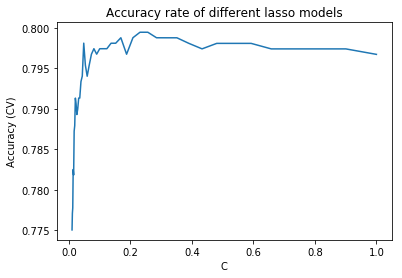

In [7]:
# tuning lasso models with differnt C parameter
lasso_lst = []
c_lst = np.logspace(-2, 0, 45)
for c in c_lst:
    lasso_lst.append(LogisticRegression(C=c, penalty='l2'))
lasso_acc_lst = [np.mean(cross_val_score(lasso, x_train, y_train, cv=KFold(10), scoring='accuracy')) for lasso in lasso_lst]
best_lasso_idx = lasso_acc_lst.index(max(lasso_acc_lst))
models['Lasso'] = lasso_lst[best_lasso_idx]

# plot the accuracy rate of differnt lasso models
plt.plot(c_lst, lasso_acc_lst)
plt.title('Accuracy rate of different lasso models')
plt.xlabel('C')
plt.ylabel('Accuracy (CV)')
plt.show()

#### ElasticNet

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

parametersGrid = {"max_iter": [1, 5, 10],
                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.1)}

scaler = StandardScaler()
x_train_sd = scaler.fit_transform(x_train)
eNet = SGDClassifier(loss='modified_huber')
grid = GridSearchCV(eNet, parametersGrid, scoring='accuracy', cv=10)
grid.fit(x_train_sd, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_iter': [1, 5, 10], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [9]:
# the best ElasticNet estimator
best_elastic = grid.best_estimator_

# the accuracy rate of the ElasticNet model
elastic_acc = grid.best_score_
print('The accuracy rate of optimal ElasticNet: {}'.format(elastic_acc))

The accuracy rate of optimal ElasticNet: 0.7994579945799458


#### MARS

In [10]:
models['MARS'] = Pipeline([('earth', Earth()),('logistic', LogisticRegression())])

#### Decision tree

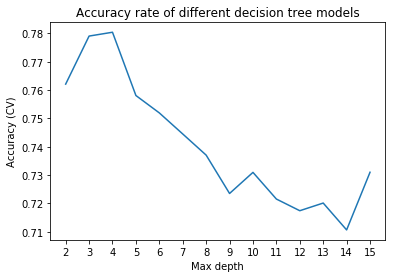

In [11]:
# tuning decisino tree models with different max_depth
tree_lst = []
for d in range(2, 16):
    tree_lst.append(DecisionTreeClassifier(max_depth=d))
tree_acc_lst = [np.mean(cross_val_score(tree, x_train, y_train, cv=KFold(10), scoring='accuracy')) for tree in tree_lst]
best_tree_idx = tree_acc_lst.index(max(tree_acc_lst))
models['Tree'] = tree_lst[best_tree_idx]

# plot the accuracy rate of different decision tree models
plt.plot(np.arange(2,16), tree_acc_lst)
plt.title('Accuracy rate of different decision tree models')
plt.xlabel('Max depth')
plt.ylabel('Accuracy (CV)')
plt.xticks(np.arange(2, 16))
plt.show()

#### Bagging

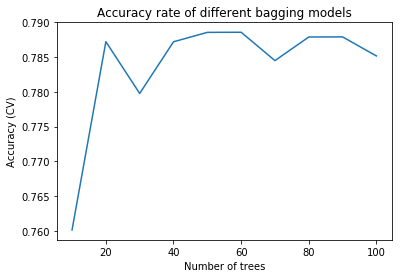

In [12]:
# tuning bagging models with different number of trees
bagging_lst = []
n_tree = np.arange(10, 110, 10)
for n in n_tree:
    bagging_lst.append(BaggingClassifier(n_estimators=n))
bagging_acc_lst = [np.mean(cross_val_score(bagging, x_train, y_train, cv=KFold(10), scoring='accuracy')) for bagging in bagging_lst]
best_bagging_idx = bagging_acc_lst.index(max(bagging_acc_lst))
models['Bagging'] = bagging_lst[best_bagging_idx]

# plot the accuracy rate of different bagging models
plt.plot(n_tree, bagging_acc_lst)
plt.title('Accuracy rate of different bagging models')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy (CV)')
plt.show()

#### Random forest

In [13]:
# tuning random forest models with different n_estimators and max_depth
n_estimators = np.arange(10, 55, 5)
max_depth = np.arange(2, 8)
forest_lst = []
forest_acc_lst = []
for n in n_estimators:
    forest_lst_tmp = []
    forest_acc_lst_tmp = []
    for d in max_depth:
        forest = RandomForestClassifier(n_estimators=n, max_depth=d)
        forest_lst_tmp.append(forest)
        forest_acc_lst_tmp.append(np.mean(cross_val_score(forest, x_train, y_train, cv=KFold(10), scoring='accuracy')))
    best_idx = np.argmax(forest_acc_lst_tmp)
    best_forest = forest_lst_tmp[best_idx]
    best_forest_acc = forest_acc_lst_tmp[best_idx]
    forest_lst.append(best_forest)
    forest_acc_lst.append(best_forest_acc)

best_forest_idx = forest_acc_lst.index(max(forest_acc_lst))
models['Random Forest'] = forest_lst[best_forest_idx]

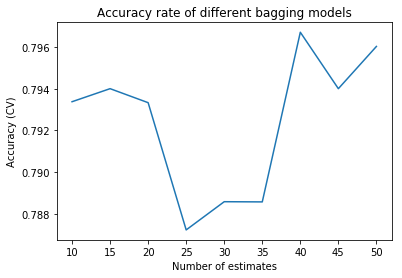

In [14]:
# plot the accuracy rate of different bagging models 
plt.plot(n_estimators, forest_acc_lst)
plt.title('Accuracy rate of different bagging models')
plt.xlabel('Number of estimates')
plt.ylabel('Accuracy (CV)')
plt.show()

#### Boosting

In [15]:
# tuning boosting models with n_estimators and max_depth
n_estimators = np.arange(10, 55, 5)
max_depth = np.arange(2, 8)
boost_lst = []
boost_acc_lst = []
for n in n_estimators:
    boost_lst_tmp = []
    boost_acc_lst_tmp = []
    for d in max_depth:
        boost = xgb.XGBClassifier(n_estimators=n, max_depth=d)
        boost_acc_lst_tmp.append(np.mean(cross_val_score(boost, x_train, y_train, cv=KFold(10), scoring='accuracy')))
        boost_lst_tmp.append(boost)
    best_idx = np.argmax(boost_acc_lst_tmp)
    best_boost = boost_lst_tmp[best_idx]
    best_boost_acc = boost_acc_lst_tmp[best_idx]
    boost_lst.append(best_boost)
    boost_acc_lst.append(best_boost_acc)

best_boost_idx = boost_acc_lst.index(max(boost_acc_lst))
models['Boosting'] = boost_lst[best_boost_idx]

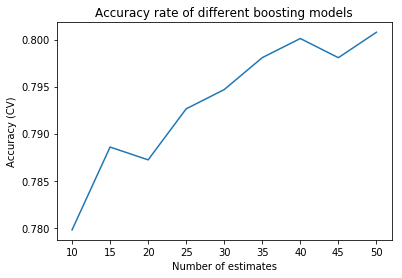

In [16]:
# plot the accuracy rate of different boosting models
plt.plot(n_estimators, boost_acc_lst)
plt.title('Accuracy rate of different boosting models')
plt.xlabel('Number of estimates')
plt.ylabel('Accuracy (CV)')
plt.show()

### Evaluate statistical models

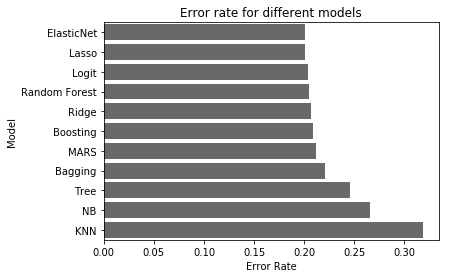

In [17]:
# calculate error rate and ROC/AUC for each model
models_err_lst = []
models_auc_lst = []
for model in models:
    err = 1 - np.mean(cross_val_score(models[model], x_train, y_train, cv=KFold(5), scoring='accuracy'))
    auc = np.mean(cross_val_score(models[model], x_train, y_train, cv=KFold(5), scoring='roc_auc'))
    models_err_lst.append((model, err))
    models_auc_lst.append((model, auc))
models_err_lst.append(('ElasticNet', 1-elastic_acc))

# plot error rate for different models    
import seaborn as sns
err_df = pd.DataFrame(models_err_lst)
err_df = err_df.rename(columns = {0:'Model', 1:'Error Rate'})

sns.barplot(x='Error Rate', y='Model', data = err_df.sort_values('Error Rate'), color='dimgrey')
plt.title('Error rate for different models')
plt.show()

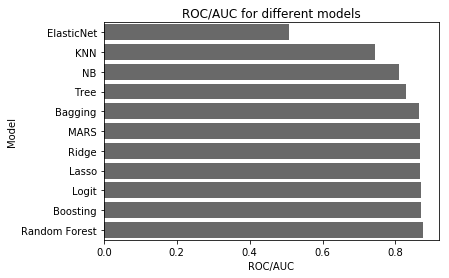

In [18]:
# get ROC/AUC score for the optimal ElasticNet
pred_prob_en =best_elastic.predict_proba(x_test)[:,1]
roc_auc_en = roc_auc_score(y_test, pred_prob_en)
models_auc_lst.append(('ElasticNet',roc_auc_en ))

# plot ROC/AUC for different models
auc_df = pd.DataFrame(models_auc_lst)
auc_df = auc_df.rename(columns = {0:'Model', 1:'ROC/AUC'})
sns.barplot(x='ROC/AUC', y='Model', data = auc_df.sort_values('ROC/AUC'), color='dimgrey')
plt.title('ROC/AUC for different models')
plt.show()

According to the plots above, ElasticNet model has the lowest CV error rate. However, Random Forest model has the highest ROC/AUC. A higher AUC can better deal with situations where we have a very skewed sample distribution, and don't want to overfit to a single class. Therefore, to me, the best model is the one having the highest ROC/AUC, which in this case is the Random Forest model.

### Interpret the best model

#### Feature Importance

In [19]:
from skater.model import InMemoryModel
from skater.core.explanations import Interpretation

best_model = models['Random Forest'].fit(x_train, y_train)
# calculate the feature importance
model = InMemoryModel(best_model.predict_proba, examples = x_train)
interpreter = Interpretation(x_train)
importance = interpreter.feature_importance.feature_importance(model)

2019-03-04 11:43:29,408 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[55/55] features ████████████████████ Time elapsed: 6 seconds

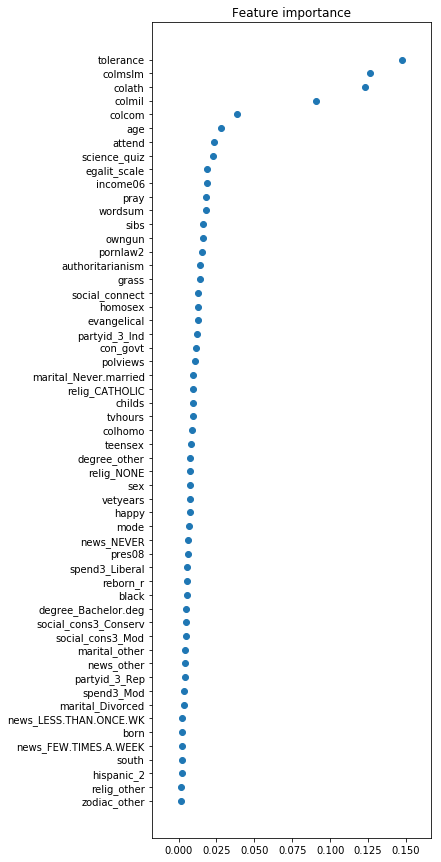

In [20]:
# plot the feature importance
features = np.array(gss_train.drop(['colrac'], axis=1).columns)
plt.figure(figsize=(5,15))
yrange = np.arange(0,len(features))
plt.scatter(importance, yrange)
plt.yticks(yrange, features[importance.index])
plt.title('Feature importance')
plt.show()

From the feature importance figure, we can know that the 5 most important features are 'tolerance','colmslm' 'colath', 'colmil', and 'colcom'.

#### PDPs/ICE

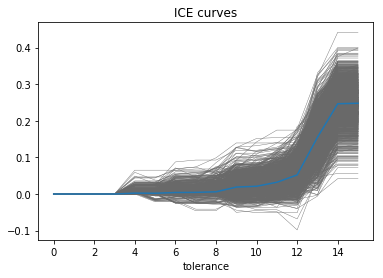

In [21]:
from pycebox.ice import ice, ice_plot

ice_data = gss_train.drop(['colrac'], axis=1)
pred_func = lambda x:best_model.predict_proba(x)[:,0]

# plot ICE curves and PDP of tolerance
ice_df = ice(ice_data, 'tolerance', pred_func)
ice_plot(ice_df, c='dimgray', linewidth=0.4, plot_pdp=True, centered=True)
plt.title('ICE curves')
plt.xlabel('tolerance')
plt.show()

From the PDPs/ICE of 'tolerance', 'colrac' increases as 'tolerance' grows larger.

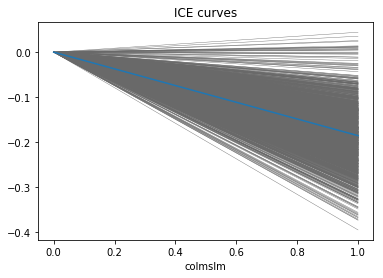

In [22]:
# plot ICE curves and PDP of colmslm
ice_df = ice(ice_data, 'colmslm', pred_func)
ice_plot(ice_df, c='dimgray', linewidth=0.4, plot_pdp=True, centered=True)
plt.title('ICE curves')
plt.xlabel('colmslm')
plt.show()

From the PDPs/ICE of 'colmslm', 'colrac' decreases as 'colmslm' grows larger.

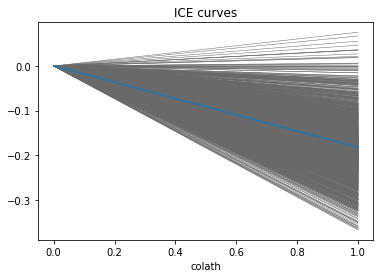

In [23]:
# plot ICE curves and PDP of colath
ice_df = ice(ice_data, 'colath', pred_func)
ice_plot(ice_df,c='dimgray', linewidth=0.5, plot_pdp=True, centered=True)
plt.title('ICE curves')
plt.xlabel('colath')
plt.show()

From the PDPs/ICE of 'colath', 'colrac' decreases as 'colath' grows larger.

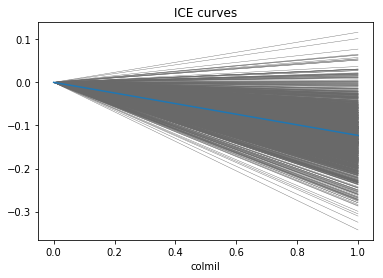

In [24]:
# plot ICE curves and PDP of colmil
ice_df = ice(ice_data, 'colmil', pred_func)
ice_plot(ice_df, c='dimgray', linewidth=0.4, plot_pdp=True, centered=True)
plt.title('ICE curves')
plt.xlabel('colmil')
plt.show()

From the PDPs/ICE of 'colmil', 'colrac' decreases as 'colmil' grows larger.

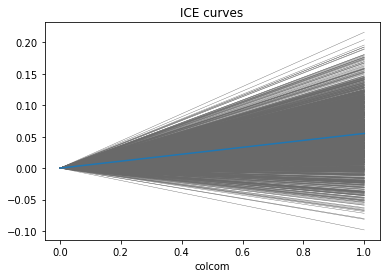

In [25]:
# plot ICE curves and PDP of colcom
ice_df = ice(ice_data, 'colcom', pred_func)
ice_plot(ice_df, c='dimgray', linewidth=0.4, plot_pdp=True, centered=True)
plt.title('ICE curves')
plt.xlabel('colcom')
plt.show()

From the PDPs/ICE of 'science_quiz', 'colrac' increases when 'colcom' becomes larger.

#### Local explanations (LIME)

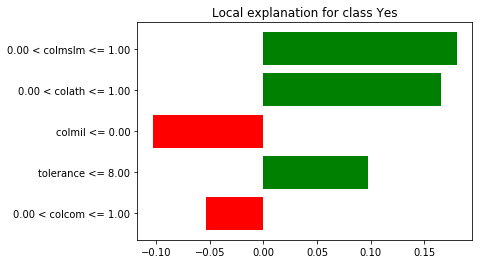

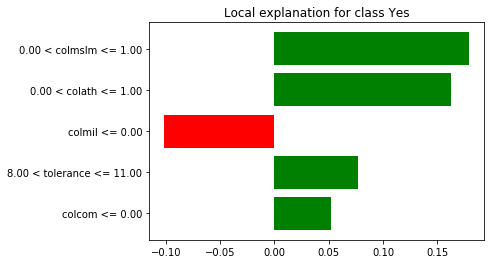

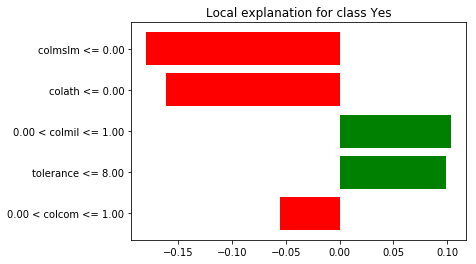

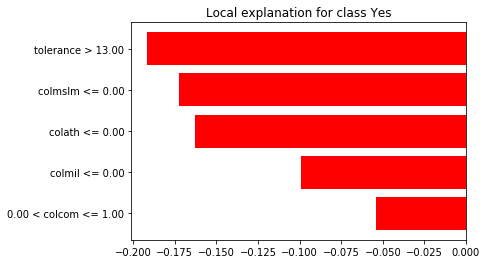

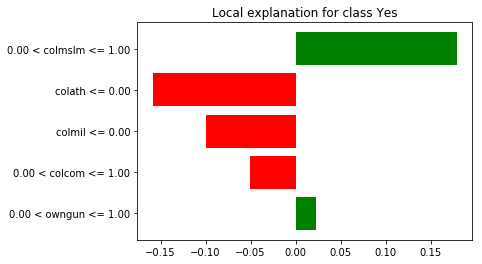

In [26]:
import lime
import lime.lime_tabular

# load the local data 
local = pd.read_csv('./data/gss_local.csv').drop(['colrac'], axis=1)

names = list(gss_train.drop(['colrac'], axis=1).columns)
predict_fn = lambda x:best_model.predict_proba(x)

# local surrogate model using the default hyperparameters for lime 
explainer = lime.lime_tabular.LimeTabularExplainer(x_train, feature_names= names, 
                                                   class_names=['No', 'Yes'],  feature_selection='auto')

# plot the tuned Lime
for i in range(5):
    explainer.explain_instance(local.loc[i].values, predict_fn, num_features=5).as_pyplot_figure()

The direction of the 5 most important feature vary among different observations from local explanation(LIME).

### Evaluate the best model

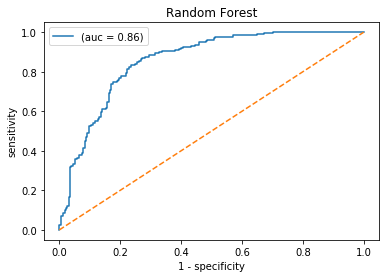

In [34]:
from sklearn import metrics
# get the error rate and ROC/AUC for the best model
pred_prob =best_model.predict_proba(x_test)[:,1]
pred = best_model.predict(x_test)
err_rf = 1 - accuracy_score(y_test, pred)
roc_auc_rf = roc_auc_score(y_test, pred_prob)

# plot AUC of Random Forest model
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)
plt.plot(fpr, tpr, label='(auc = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('1 - specificity')
plt.ylabel('sensitivity')
plt.title('Random Forest')
plt.legend()
plt.show()

In [35]:
print('''
The train error rate of Random Forest: {}
The train ROC/AUC of Random Forest: {}
The test error rate of Random Forest: {}
The test ROC/AUC of Random Forest: {}
'''.format(err_df.at[8, 'Error Rate'],auc_df.at[8, 'ROC/AUC'], err_rf, roc_auc_rf))


The train error rate of Random Forest: 0.2052908841044434
The train ROC/AUC of Random Forest: 0.8745953879174364
The test error rate of Random Forest: 0.20486815415821502
The test ROC/AUC of Random Forest: 0.856454816285998



The errot rate and ROC/AUC of training set are similar to testing dataset. Therefore, Boosting models generalizes pretty well to the test set.